<a href="https://colab.research.google.com/github/psmjazz/corona_virus/blob/master/corona.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import folium
import os
import math
from google.colab import files

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
current_dir = os.getcwd()
print('current directory : ' + current_dir)
folder = current_dir + '/drive/My Drive/dacon/corona'
data_version = '/coronavirusdataset_20200328'
data_dir = folder + data_version
print('data directory : ' + data_dir)

case_table = pd.read_csv(data_dir + '/Case.csv')
p_info_table = pd.read_csv(data_dir + '/PatientInfo.csv')
p_route_table = pd.read_csv(data_dir + '/PatientRoute.csv')
region = pd.read_csv(data_dir + '/Region.csv')

current directory : /content
data directory : /content/drive/My Drive/dacon/corona/coronavirusdataset_20200328


슈퍼 전파자 파악




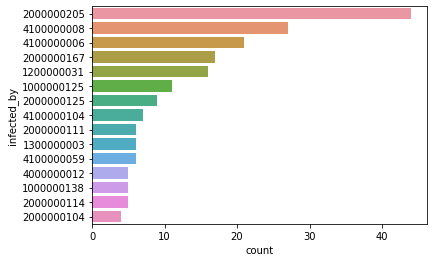

In [3]:
# spreader_count = dict()
spreader_count = None
spreader_count = p_info_table[['infected_by']]\
    .dropna(axis = 0).astype('int')\
    .groupby('infected_by')['infected_by'].count().reset_index(name = 'count')\
    .sort_values(['count'], ascending = False)

top_15 = spreader_count.head(15)
top_15.index
sns.barplot(x = 'count',y = 'infected_by',
            data = top_15, orient = 'h',
            order = top_15['infected_by'])

In [4]:

# spreader_count = dict()
spreader_count = None
spreader_count = p_info_table[['infected_by', 'infection_case']]\
    .dropna(axis = 0)\
    .astype({'infected_by' : int})\
    .groupby(['infected_by', 'infection_case'])['infected_by'].count()\
    .reset_index(name = 'count')\
    .sort_values(['count'], ascending = False)
spreader_count.head(15)

,infected_by,infection_case,count
135,2000000205,contact with patient,44
157,4100000008,gym facility in Cheonan,26
154,4100000006,contact with patient,21
132,2000000167,contact with patient,17
28,1000000125,contact with patient,11
68,1200000031,contact with patient,10
127,2000000125,contact with patient,9
183,4100000104,contact with patient,7
173,4100000059,contact with patient,6
122,2000000111,contact with patient,6


id 2000000205인 환자가 총 44명에게 전파, 이들은 단순하게 환자와 접촉했음
-> null 값이 많아 확실한 추측은 안됨

감영 경로 추적\
사람들의 감염 경로 추적\
환자의 다른 지역에 감염 정도를 지도에 표시\
확진자의 위치는 city province의 값으로\
같은 동네(city)의 확진자는 같은 위치에 표시되기 때문에 약간의 오차를 적용하여구분 가능하게 만들었습니다.\
jitter 함수 : 위도와 경도에 약간의 오차를 추가\
get_location 함수 : 확진자의 city 혹은 province 값에 해당하는 위도와 경도를 반환\
draw_color 함수 : 전파자와 감염자간 위치를 직선으로 연결, 파란 원 안의 사람들은 같은 지역(city)
> 1차 확진자 : red\
> 2차 확진자 : orange\
> 3차 확진자 : yellow\
> 4차 확진자 : purple\
> 지역내 감염(같은 지역에 사는 사람끼리 감염)은 원으로 표현하였습니다\
> 파란 원 안에 선분의 꼭지점이나 원이 없으면 그 city는 2차 이상 감염자가 없음을 뜻함


In [0]:
def jitter(x) :
    lat_jit = np.random.normal(0, x)
    long_jit = np.random.normal(0, x)
    return lat_jit, long_jit

def id_jitter(id, std):
    digit9_id = id // 1000000 * 100000 + id % 100000
    np.random.seed(digit9_id)
    lat_jit = np.random.normal(0, std)
    long_jit = np.random.normal(0, std)
    return lat_jit, long_jit

def get_location(info):
    info = info.reset_index()
    region_info = None
    if info.loc[0, 'city'] is np.nan or info.loc[0, 'city'] ==  'etc':
        region_info = region[region['city'] == info.loc[0, 'province']]
    else:
        region_info = region[region['city'] == info.loc[0, 'city']]
    return region_info.reset_index().loc[0, ['latitude', 'longitude']]

depth_color = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']

def draw_spreading_line(spreader, patient, depth, m):
    spreader_info = p_info_table[p_info_table['patient_id'] == spreader]
    patient_info = p_info_table[p_info_table['patient_id'] == patient]
    # line = [list(get_location(spreader_info)), list(get_location(patient_info))]
    spreader_pos = list(get_location(spreader_info))
    patient_pos = list(get_location(patient_info))

    inform = (
        spreader_info['patient_id'].to_string(index = False)
        + ' ('+ spreader_info['province'].to_string(index = False)
        + (lambda x : x.to_string(index = False) if x.values[0] is not np.nan else '')(spreader_info['city'])
        + ' ) ->'
        + patient_info['patient_id'].to_string(index = False)
        + ' ('+ patient_info['province'].to_string(index = False)
        + (lambda x : x.to_string(index = False) if x.values[0] is not np.nan else '')(patient_info['city'])
        + ' )'
    )

    jit_s_lat, jit_s_long = id_jitter(spreader, 0.0005)
    jit_p_lat, jit_p_long = id_jitter(patient, 0.0005)

    # if(depth > 0):
    #     print('??? : ' +str(depth))
    # else:
    #     return
    if spreader_pos == patient_pos:
        spreader_pos[0] += jit_s_lat
        spreader_pos[1] += jit_s_long
        patient_pos[0] += jit_p_lat
        patient_pos[1] += jit_p_long
        folium.PolyLine(
            locations = [spreader_pos, patient_pos],
            color = depth_color[depth],
            tooltip = inform
        ).add_to(m)
        folium.Circle(
            location=patient_pos, 
            fill_color = depth_color[depth],
            color = depth_color[depth],
            radius=5, 
            tooltip = inform + '   '+str(depth)
            ).add_to(m)
        # if(depth > 0):
        #     print('ok : '+str(depth))
    else:
        spreader_pos[0] += jit_s_lat
        spreader_pos[1] += jit_s_long
        patient_pos[0] += jit_p_lat
        patient_pos[1] += jit_p_long
        folium.PolyLine(
            locations = [spreader_pos, patient_pos],
            color = depth_color[depth],
            tooltip = inform
        ).add_to(m)
        folium.RegularPolygonMarker(
            location=patient_pos, 
            fill_color=depth_color[depth],
            color =  depth_color[depth],
            number_of_sides=4, 
            radius=5, 
            tooltip = inform  + '   '+str(depth)
            ).add_to(m)
        # if(depth > 0):
        #     print('ok : '+str(depth))

# center = [37.541, 126.986]
# m = folium.Map(location=center, zoom_start=13, width = 1200, height = 700)
# draw_spreading_line(1100000001,1000000299, 0, m)
# draw_spreading_line(1000000156,1000000157, 1, m)
# draw_spreading_line(1000000165,1000000299, 2, m)
# draw_spreading_line(1100000001,1000000157, 3, m)
# draw_spreading_line(1000000156,1000000299, 4, m)
# m

In [6]:
patient_and_spreader = p_info_table[['patient_id', 'infected_by']].dropna(axis = 0).astype('int64')
infection_route = dict()
rir = dict()
# spreader_root = set()
# child = set()
for i in patient_and_spreader.index:
    patient = patient_and_spreader.loc[i, 'patient_id']
    spreader = patient_and_spreader.loc[i, 'infected_by']
    
#     child.add(patient)
#     if spreader not in child:
#     spreader_root.add(spreader)
#     if patient in spreader_root:
#         spreader_root.remove(patient)
    rir[patient] = spreader
    if spreader in infection_route:
        infection_route[spreader].append(patient)        
    else:
        infection_route[spreader] = [patient]
# spreader_root = list(spreader_root)
# for spreader in spreader_root:
#     patients = infection_route[spreader]
#     for patient in patients:
#         if patient in spreader_root:
#             spreader_root.remove(patient)
spreader_root = set()

for spreader in infection_route.keys():
    maybe_cycle = [spreader]
    while spreader in rir:
        spreader = rir[spreader]
        if spreader in maybe_cycle:
            print('cycle!!!', maybe_cycle)
            break
        maybe_cycle.append(spreader)
    spreader_root.add(spreader)
print(len(spreader_root))

cycle!!! [1100000028]
cycle!!! [1300000011, 1300000010]
cycle!!! [1300000010, 1300000011]
cycle!!! [4100000006, 4100000007]
cycle!!! [4100000007, 4100000006]
cycle!!! [4100000070, 4100000052]
cycle!!! [4100000059, 4100000006, 4100000007]
cycle!!! [4100000052, 4100000070]
cycle!!! [4100000033, 4100000006, 4100000007]
cycle!!! [4100000074, 4100000006, 4100000007]
cycle!!! [4100000086, 4100000059, 4100000006, 4100000007]
cycle!!! [4100000083, 4100000006, 4100000007]
cycle!!! [4100000050, 4100000006, 4100000007]
136


In [7]:
center = [37.541, 126.986]
m = folium.Map(location=center, zoom_start=13, width = 1200, height = 700)
#city의 중심 표시
for i in range(len(region)):
    # print(region.loc[i, ['latitude', 'longitude']])
    folium.Circle(
        location = region.loc[i, ['latitude', 'longitude']],
        radius = 180,
        color = 'black',
        fill_color='black',
        tooltip = region.loc[i, ['city']].to_string(index = False)
    ).add_to(m)

# Breadth-first search를 통한 감염 단계 탐색
visited = []
queue = []
for starter in spreader_root:
    visited.append(starter)
    queue.append((starter, 0))
# print(spreader_root)

while len(queue) > 0:
    spreader, depth = queue[0]
    queue.pop(0)
#     patients = []
    for patient in infection_route[spreader]:
#         patients.append(patient)
        try:
            # cnt[depth]+=1
            # print('caller : ' + str(depth))
            draw_spreading_line(spreader, patient, depth, m)
        except KeyError:
            print('spreader id does not exist : ' + str(spreader) + ' patient : ' + str(patient))
        if patient in infection_route and patient not in visited:
            queue.append((patient, depth +1))
            visited.append(patient)
#     print(spreader, depth)
#     print(str(spreader), '|' ,str(depth), '->', patients)
# print('===========')

# while len(keys) > 0:
#     for starter in keys:
#         if starter not in visited:
#             queue = [(starter, 0)]
#             visited.append(starter)
#             break
#         else:
#             keys.pop(0)

#     while len(queue) > 0:
#         spreader, depth = queue[0]
#         queue.pop(0)
#         patients = []
#         for patient in infection_route[spreader]:
#             patients.append(patient)
#             # try:
#             #     # cnt[depth]+=1
#             #     # print('caller : ' + str(depth))
#             #     draw_spreading_line(spreader, patient, depth, m)
#             # except KeyError:
#             #     print('spreader id does not exist : ' + str(spreader) + ' patient : ' + str(patient))
#             if patient in infection_route and patient not in visited:
#                 queue.append((patient, depth +1))
#                 visited.append(patient)
#         print(str(spreader), '|' ,str(depth), '->', patients)
#     print('===========')

spreader id does not exist : 6011000384 patient : 6102000034
spreader id does not exist : 6011000384 patient : 6102000035
spreader id does not exist : 6011000384 patient : 6102000036
spreader id does not exist : 2017000005 patient : 1000000062
spreader id does not exist : 2002000001 patient : 1000000003
spreader id does not exist : 6100000072 patient : 1100000090


In [8]:
m

선분은 전파자(spreader)와 감염자(patient)를 연결\
선분에 마우스를 대면 다음과 같은 정보를 볼 수 있습니다.
> #전파자_id ( #전파자_province, #전파자_city ) -> #감염자_id ( #감염자_province, #감염자_city )

점은 전파자와 감염자가 같은 지역인 경우입니다.\
점에 마우스를 대면 다음과 같은 정보를 볼 수 있습니다.
> #전파자_id ( #전파자_province, #전파자_city ) -> #감염자_id ( #감염자_province, #감염자_city )\
> 이때 전파자의 province, city 정보와 감염자의 province, city 정보는 같습니다.\
\
insight 1 : 천안 - 아산\
> 천안과 아산 사이에는 여러 줄의 붉은 선이 보이는데 한명의 전파자(410000006)에 의해 전파
> 이후 지역사회로 급격히

In [0]:
np.random.seed(4)
print(np.random.normal(0,1))
print(np.random.normal(0,1))

0.05056170714293955
0.499951333237829


In [0]:
m